# **Imbalanced Data**

 Imbalanced data (data tak berimbang) adalah kondisi dalam dataset klasifikasi di mana jumlah data dari satu kelas (kelas mayoritas) jauh lebih banyak dibandingkan kelas lain (kelas minoritas). Ketidakseimbangan ini dapat membuat model machine learning menjadi bias, karena lebih cenderung memprediksi kelas mayoritas dan mengabaikan kelas minoritas yang seringkali lebih penting dalam kasus tertentu, seperti deteksi penyakit langka atau penipuan.

## Tugas :

1. Download dataset ecoli dari UCI https://archive.ics.uci.edu/dataset/39/ecoli
2. Simpan didatabase MySQL
3. Tampilkan data dalam scatter plot  menggunakan PCA.
   PCA mentransformasi data menjadi dimensi rendah (2)
4. Lakukan penyeimbangan data menggunakan ADASYN
5. Ploting data dari data yang diimbangkan menggunakan PCA, tandai data data hasil generatenya


## Ambil data Ecoli yang disimpan di MySQL

In [88]:
import pymysql
import pandas as pd
from tabulate import tabulate

# Konfigurasi koneksi ke database Aiven MySQL
host = "mysql23-112-irismysql23-112.h.aivencloud.com"
port = 15786
user = "avnadmin"
password = "AVNS_cTNd4CUt1kk0Z7MPIC1"
database = "defaultdb"

# Buat koneksi
mysql_conn = pymysql.connect(
    host=host,
    port=port,
    user=user,
    password=password,
    database=database,
    ssl={'ssl': {}}  # Jika menggunakan SSL
)


def fetch_mysql_data():
    try:
        conn = pymysql.connect(**mysql_config)
        cursor = conn.cursor()
        query = 'SELECT * FROM ecolipsd.ecoli_data;'
        cursor.execute(query)
        data = cursor.fetchall()
        columns = [desc[0] for desc in cursor.description]
        cursor.close()
        conn.close()
        df = pd.DataFrame(data, columns=columns)

        return df
    except pymysql.err.OperationalError as e:
        print(f"Error connecting to MySQL: {e}")
        return pd.DataFrame()


df = fetch_mysql_data()
print(tabulate(df, headers='keys', tablefmt='grid'))

+-----+------------+-------+-------+-------+-------+-------+--------+--------+---------+
|     | Sequence   |   mcg |   gvh |   lip |   chg |   aac |   alm1 |   alm2 | class   |
+=====+============+=======+=======+=======+=======+=======+========+========+=========+
|   0 | AAS_ECOLI  |  0.44 |  0.52 |  0.48 |   0.5 |  0.43 |   0.47 |   0.54 | im      |
+-----+------------+-------+-------+-------+-------+-------+--------+--------+---------+
|   1 | AAT_ECOLI  |  0.49 |  0.29 |  0.48 |   0.5 |  0.56 |   0.24 |   0.35 | cp      |
+-----+------------+-------+-------+-------+-------+-------+--------+--------+---------+
|   2 | ACEA_ECOLI |  0.07 |  0.4  |  0.48 |   0.5 |  0.54 |   0.35 |   0.44 | cp      |
+-----+------------+-------+-------+-------+-------+-------+--------+--------+---------+
|   3 | ACEK_ECOLI |  0.56 |  0.4  |  0.48 |   0.5 |  0.49 |   0.37 |   0.46 | cp      |
+-----+------------+-------+-------+-------+-------+-------+--------+--------+---------+
|   4 | ACKA_ECOLI | 

## Visualisasi data

Data ditampilkan menggunakan PCA yang mana data sudaha ditranspormasikan menjadi 2 dimensi

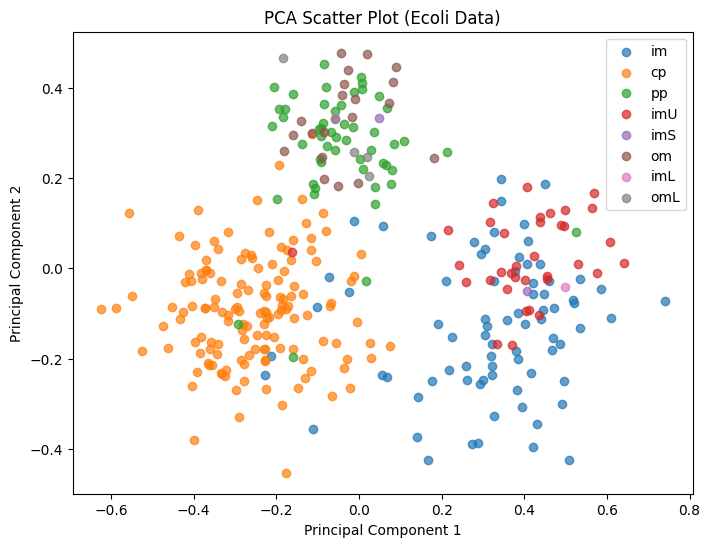

In [89]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Pisahkan fitur dan target
X = df.drop(columns=['Sequence','class'])

# Lakukan PCA ke 2 dimensi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Buat DataFrame hasil PCA
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["class"] = df["class"]  # tambahkan class untuk label warna

# Scatter plot
plt.figure(figsize=(8,6))
for c in df_pca["class"].unique():
    subset = df_pca[df_pca["class"] == c]
    plt.scatter(subset["PC1"], subset["PC2"], label=c, alpha=0.7)

plt.title("PCA Scatter Plot (Ecoli Data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


In [90]:
from imblearn.over_sampling import ADASYN
from collections import Counter

# Data preparation
nt = X.copy()
ns = y.copy()

print("Distribusi awal:", Counter(ns))

class_counts = Counter(ns)
print("Class counts:", class_counts)

# Urutkan kelas dari yang paling sedikit ke paling banyak
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1])
print("Sorted classes by count:", sorted_classes)

# Coba ADASYN bertahap untuk kelas minoritas
for i, (cls, count) in enumerate(sorted_classes[:-1]):  # Skip kelas mayoritas
    if count > 1:  # Hanya untuk kelas dengan cukup samples
        n_neighbors = min(5, count - 1)  # Pastikan n_neighbors aman

        print(f"\n📊 Processing class '{cls}' (count: {count}) with n_neighbors={n_neighbors}")

        try:
            adasyn = ADASYN(
                n_neighbors=n_neighbors,
                sampling_strategy={cls: count + 10}  # Naikkan 10 sampel
            )
            nt, ns = adasyn.fit_resample(nt, ns)
            print(f"✅ Success for class '{cls}'")
            print(f"   New distribution: {Counter(ns)}")
        except Exception as e:
            print(f"❌ Failed for class '{cls}': {e}")
            continue

print(f"\n🎯 Final distribution: {sorted(Counter(ns).items())}")

Distribusi awal: Counter({'cp': 143, 'im': 77, 'pp': 52, 'imU': 35, 'om': 20, 'omL': 5, 'imS': 2, 'imL': 2})
Class counts: Counter({'cp': 143, 'im': 77, 'pp': 52, 'imU': 35, 'om': 20, 'omL': 5, 'imS': 2, 'imL': 2})
Sorted classes by count: [('imS', 2), ('imL', 2), ('omL', 5), ('om', 20), ('imU', 35), ('pp', 52), ('im', 77), ('cp', 143)]

📊 Processing class 'imS' (count: 2) with n_neighbors=1
✅ Success for class 'imS'
   New distribution: Counter({'cp': 143, 'im': 77, 'pp': 52, 'imU': 35, 'om': 20, 'imS': 12, 'omL': 5, 'imL': 2})

📊 Processing class 'imL' (count: 2) with n_neighbors=1
✅ Success for class 'imL'
   New distribution: Counter({'cp': 143, 'im': 77, 'pp': 52, 'imU': 35, 'om': 20, 'imS': 12, 'imL': 12, 'omL': 5})

📊 Processing class 'omL' (count: 5) with n_neighbors=4
✅ Success for class 'omL'
   New distribution: Counter({'cp': 143, 'im': 77, 'pp': 52, 'imU': 35, 'om': 20, 'omL': 15, 'imS': 12, 'imL': 12})

📊 Processing class 'om' (count: 20) with n_neighbors=5
✅ Success for 

## Visualisasi Data yang Diimbangkan dengan PCA

Saya akan menerapkan PCA pada data yang sudah diseimbangkan, membuat DataFrame baru yang berisi hasil PCA dan label kelas yang sesuai, mengidentifikasi sampel asli dan yang dihasilkan, dan kemudian membuat scatter plot untuk memvisualisasikan data yang sudah diseimbangkan, menandai titik data yang baru dibuat.

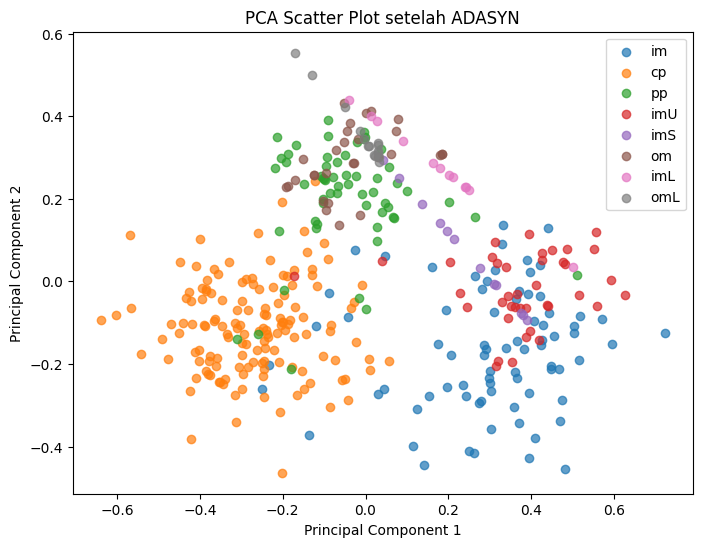

In [91]:
# Lakukan PCA ke 2 dimensi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(nt)

# Buat DataFrame hasil PCA untuk plotting
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["class"] = ns.values if isinstance(ns, pd.Series) else ns  # pastikan ns bisa dipakai

# Scatter plot
plt.figure(figsize=(8,6))
for c in df_pca["class"].unique():
    subset = df_pca[df_pca["class"] == c]
    plt.scatter(subset["PC1"], subset["PC2"], label=c, alpha=0.7)

plt.title("PCA Scatter Plot setelah ADASYN")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

## Ploting data dari data yang diimbangkan menggunakan PCA, tandai data data hasil generatenya

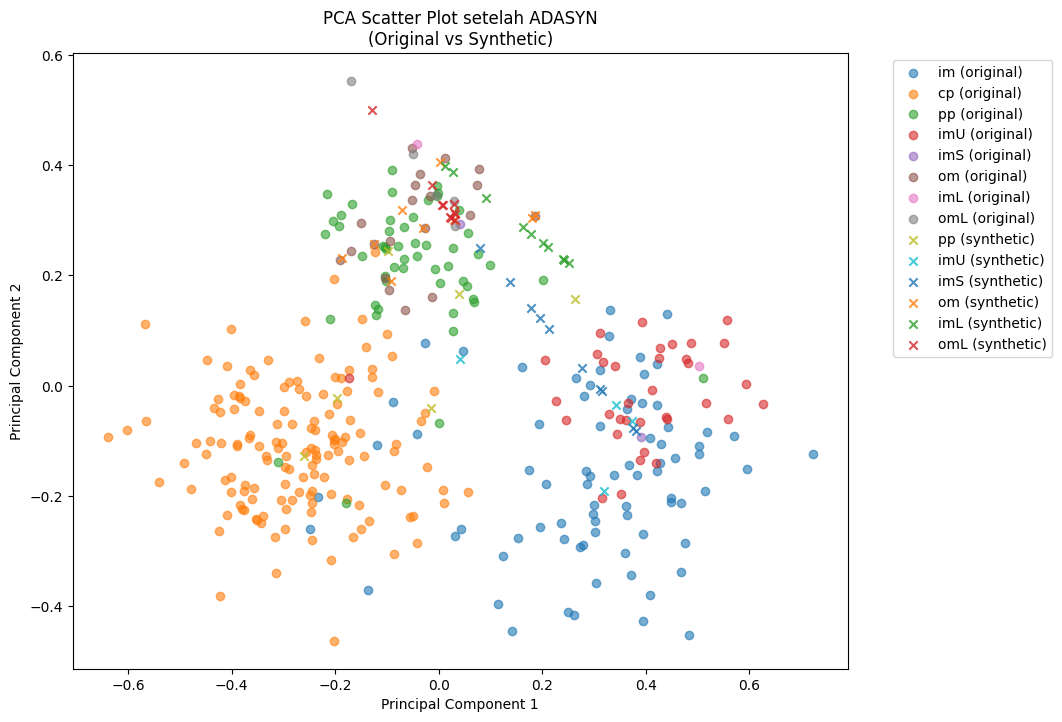

In [92]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# 1. Simpan jumlah data awal
n_original = len(X)

# 2. Lakukan PCA ke 2 dimensi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(nt)

# 3. Buat DataFrame hasil PCA untuk plotting
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["class"] = ns.values if isinstance(ns, pd.Series) else ns

# Tandai data asli vs synthetic
df_pca["status"] = ["original"] * n_original + ["synthetic"] * (len(df_pca) - n_original)

# 4. Scatter plot dengan penanda synthetic
plt.figure(figsize=(10,8))

# Plot data original
for c in df_pca["class"].unique():
    subset = df_pca[(df_pca["class"] == c) & (df_pca["status"] == "original")]
    plt.scatter(subset["PC1"], subset["PC2"], label=f"{c} (original)", alpha=0.6, marker='o')

# Plot data synthetic (pakai marker berbeda)
for c in df_pca["class"].unique():
    subset = df_pca[(df_pca["class"] == c) & (df_pca["status"] == "synthetic")]
    if not subset.empty:
        plt.scatter(subset["PC1"], subset["PC2"], label=f"{c} (synthetic)", alpha=0.8, marker='x')

plt.title("PCA Scatter Plot setelah ADASYN\n(Original vs Synthetic)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
